In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import savetxt
from scipy.ndimage.interpolation import shift

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, AveragePooling1D, SimpleRNN, LSTM


In [7]:
#Loading data from PC- data:full original vector of solar irradiance 
data = pd.read_csv("solar_30min.csv", names=['irradiance'])
print(data.head())

   irradiance
0       0.000
1      10.065
2      46.785
3      97.420
4     239.070


In [8]:
data = data.values
print("Shape of data is ", data.shape)

Shape of data is  (9000, 1)


In [9]:
sigma = np.std(data)
mu = np.mean(data)
datanorm = (data-mu)/sig

The shape of datamat is  (360, 25)


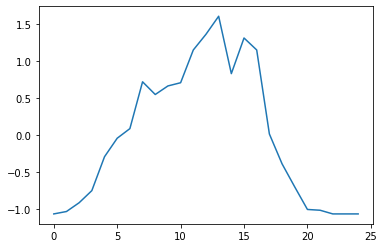

In [12]:
#Random shuffling to matrix across rows
datamat = data.reshape(360,-1)
print("The shape of datamat is ", datamat.shape)
datamat_norm = datanorm.reshape(360,-1)
plt.plot(datamat_norm[0])
datanorm = datamat_norm.reshape(-1,1)

In [46]:
#Function to Split into input ouput sets
def split_seq(seq, n_steps):
    X, y = list(), list()
    for i in range(len(seq)):
    
        #Find end of seq
        end_ix = i+n_steps
        #Check if sequence passed
        if end_ix>len(seq)-1:
            break

        #Gather input and ouputs
        seq_x, seq_y = seq[i:end_ix], seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [47]:
n_steps = 4
trainval = 25*256 + 1

unk,y_recon = split_seq(datanorm, n_steps)
y_recon = y_recon[trainval :]

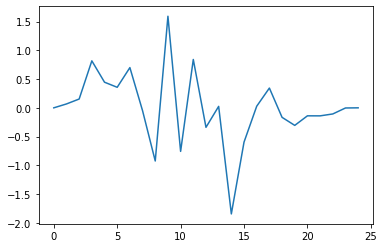

In [48]:
data_diff = datanorm-np.roll(datanorm,1)
plt.plot(data_diff[0:25])

In [49]:
#Training, Testing data split
trainX_diff = data_diff[0:trainval]
testX_diff = data_diff[trainval:]

In [50]:
n_steps = 4
n_features = 1

#Split into inputs, outputs for training data
Xdiff_train, Ydiff_train= split_seq(trainX_diff, n_steps)

Xdiff_train = Xdiff_train.reshape(Xdiff_train.shape[0],Xdiff_train.shape[1], n_features)

#Split into input and outputs for test data
Xdiff_test, Ydiff_test = split_seq(testX_diff, n_steps)

Xdiff_test = Xdiff_test.reshape(Xdiff_test.shape[0], Xdiff_test.shape[1], n_features)

In [133]:
#Define Model
model = tf.keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
model.add(AveragePooling1D(pool_size=2))
model.add(Flatten())
# model.add(LSTM(32, activation='tanh', input_shape=(n_steps, n_features), dropout=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 2, 64)             256       
_________________________________________________________________
average_pooling1d_4 (Average (None, 1, 64)             0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_38 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 33        
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
___________________________________________________

In [134]:
#Fit model to difference transformed model
hist = model.fit(Xdiff_train, Ydiff_train, epochs=30, batch_size=64, validation_split=0.15, verbose=1, shuffle=False)

Train on 5437 samples, validate on 960 samples
Epoch 1/30
5437/5437 [==============================] - 1s 259us/sample - loss: 0.3133 - val_loss: 0.2804
Epoch 2/30
5437/5437 [==============================] - 1s 98us/sample - loss: 0.2898 - val_loss: 0.2679
Epoch 3/30
5437/5437 [==============================] - 1s 97us/sample - loss: 0.2827 - val_loss: 0.2661
Epoch 4/30
5437/5437 [==============================] - 1s 94us/sample - loss: 0.2790 - val_loss: 0.2656
Epoch 5/30
5437/5437 [==============================] - 1s 93us/sample - loss: 0.2764 - val_loss: 0.2654
Epoch 6/30
5437/5437 [==============================] - 1s 93us/sample - loss: 0.2751 - val_loss: 0.2655
Epoch 7/30
5437/5437 [==============================] - 1s 93us/sample - loss: 0.2734 - val_loss: 0.2653
Epoch 8/30
5437/5437 [==============================] - 1s 93us/sample - loss: 0.2722 - val_loss: 0.2651
Epoch 9/30
5437/5437 [==============================] - 1s 93us/sample - loss: 0.2707 - val_loss: 0.2650
Epoch 1

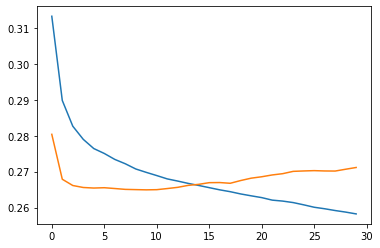

In [135]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='Cross validation')

In [136]:
#Predicting difference transformed data using NN model
yhat_difftest = model.predict(Xdiff_test, verbose=0)

In [137]:
ypred = (yhat_difftest + y_recon)*sigma +mu
yact = (Ydiff_test + y_recon)*sigma +mu

In [138]:
RMSE = np.sqrt(sum((ypred-yact)**2)/len(ypred))
print(f"RMSE is {RMSE}", )

RMSE is [155.56696978]
